# **Lab 9 Numba Python**

###Install compatible cuda and driver versions.
Only needs to be done once while the environment is connected and active.

In [6]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [7]:
!apt-get -y install cuda-12-4

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cpp-12 cuda-cccl-12-4 cuda-command-line-tools-12-4 cuda-compiler-12-4
  cuda-crt-12-4 cuda-cudart-12-4 cuda-cudart-dev-12-4 cuda-cuobjdump-12-4
  cuda-cupti-12-4 cuda-cupti-dev-12-4 cuda-cuxxfilt-12-4 cuda-demo-suite-12-4
  cuda-documentation-12-4 cuda-driver-dev-12-4 cuda-drivers cuda-drivers-570
  cuda-gdb-12-4 cuda-libraries-12-4 cuda-libraries-dev-12-4 cuda-nsight-12-4
  cuda-nsight-compute-12-4 cuda-nsight-systems-12-4 cuda-nvcc-12-4
  cuda-nvdisasm-12-4 cuda-nvml-dev-12-4 cuda-nvprof-12-4 cuda-nvprune-12-4
  cuda-nvrtc-12-4 cuda-nvrtc-dev-12-4 cuda-nvtx-12-4 cuda-nvvm-12-4
  cuda-nvvp-12-4 cuda-opencl-12-4 cuda-opencl-dev-12-4 cuda-profiler-api-12-4
  cuda-runtime-12-4 cuda-sanitizer-12-4 cuda-toolkit-12-4
  cuda-toolkit-12-4-config-common cuda-tools-12-4 cuda-visual-tools-12-4
  dctrl-tools default-jre default-jre-headless dkms f

In [8]:
!ls /usr/local/cuda-12.4/
!update-alternatives --set cuda /usr/local/cuda-12.4

bin		   EULA.txt  lib64	       nvvm    targets
compute-sanitizer  extras    libnvvp	       README  tools
doc		   gds	     nsightee_plugins  share   version.json
DOCS		   include   nvml	       src
update-alternatives: using /usr/local/cuda-12.4 to provide /usr/local/cuda (cuda) in manual mode


In [9]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Mar_28_02:18:24_PDT_2024
Cuda compilation tools, release 12.4, V12.4.131
Build cuda_12.4.r12.4/compiler.34097967_0


Mount Google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


You must change directory to the path where the code for this lab is uploaded.

In [ ]:
%cd drive/MyDrive/SP25-HPC/Assignments/Mod9-Lab-NumbaPython/

1. Prepare a Grayscale Input Image
In this cell we download a sample image (the classic “Lenna”), convert it to grayscale, and save it as input.png.

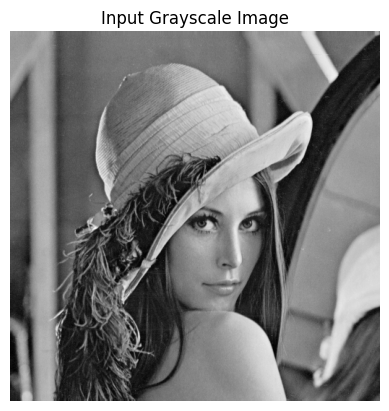

In [10]:
import cv2
import urllib.request
import numpy as np
from matplotlib import pyplot as plt

# Download a sample image (Lenna)
url = 'https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png'
resp = urllib.request.urlopen(url)
image_data = np.asarray(bytearray(resp.read()), dtype="uint8")
image = cv2.imdecode(image_data, cv2.IMREAD_COLOR)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2.imwrite("input.png", gray)

# Display the grayscale image
plt.imshow(gray, cmap='gray')
plt.title("Input Grayscale Image")
plt.axis('off')
plt.show()


In [11]:
from numba import cuda, int32
import numpy as np
import math

##Problem 1 Image Blur

###Problem 1: blur_kernel code here

In [13]:
# -------- CPU Reference Function --------
def blur_cpu(img):
    """
    CPU version for validation: 9x9 average blur using numpy.
    """
    height, width = img.shape
    output = np.zeros_like(img)

    for y in range(height):
        for x in range(width):
            total = 0
            count = 0
            for dy in range(-4, 5):
                for dx in range(-4, 5):
                    ny = y + dy
                    nx = x + dx
                    if 0 <= ny < height and 0 <= nx < width:
                        total += img[ny, nx]
                        count += 1
            output[y, x] = total // count
    return output

In [12]:
@cuda.jit
def blur_kernel(input_img, output_img, width, height):
    """
    GPU kernel to apply a 9×9 blur (average) on a grayscale image.
    Each pixel is replaced by the average of its neighbors in a 9×9 window.
    """

    """ INSERT KERNEL CODE HERE """
        # Get 2D coordinates of the current thread
    y, x = cuda.grid(2)

    # Read image shape
    height, width = input_img.shape

    # Blur radius = 4 (for 9x9 window)
    radius = 4

    # Check if thread's pixel is inside image bounds
    if y < height and x < width:
        total = 0
        count = 0

        # Loop over 9x9 neighborhood
        for dy in range(-radius, radius + 1):
            for dx in range(-radius, radius + 1):
                ny = y + dy
                nx = x + dx

                # Only accumulate valid pixels
                if 0 <= ny < height and 0 <= nx < width:
                    total += input_img[ny, nx]
                    count += 1

        # Integer average
        output_img[y, x] = total // count

###Problem 1: Kernel Launch, Validation Code Here

In [16]:
from skimage import filters

# DEBUG/TEST ONLY
# Create a dummy grayscale image (height × width)
height, width = 1024, 1024
img = np.random.randint(0, 256, size=(height, width), dtype=np.uint8)
out = np.empty_like(img)

#NOTE: Use the image from the above code for submission.

# Transfer to GPU
    # INSERT CODE HERE
d_img=cuda.to_device(img) #Device image
d_out=cuda.device_array_like(img) #Image from the device

# Configure kernel launch
threads_per_block = (16, 16)
blocks_per_grid_x = math.ceil(width / threads_per_block[0])
blocks_per_grid_y = math.ceil(height / threads_per_block[1])
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

# Launch Kernel
    # INSERT CODE HERE blur_kernel()
blur_kernel[blocks_per_grid, threads_per_block](d_img, d_out, width, height)

# Copy result back
    # INSERT CODE HERE
d_out.copy_to_host(out)


# INSERT CODE HERE VALIDATION CODE HERE
    #This should be a visual comparison against the The Gaussian blur
    #using a low-pass filter in scikit-image
ref_blur = filters.gaussian(img, sigma=2, truncate=2.0, mode='nearest')
ref_blur = (ref_blur * 255).astype(np.uint8)

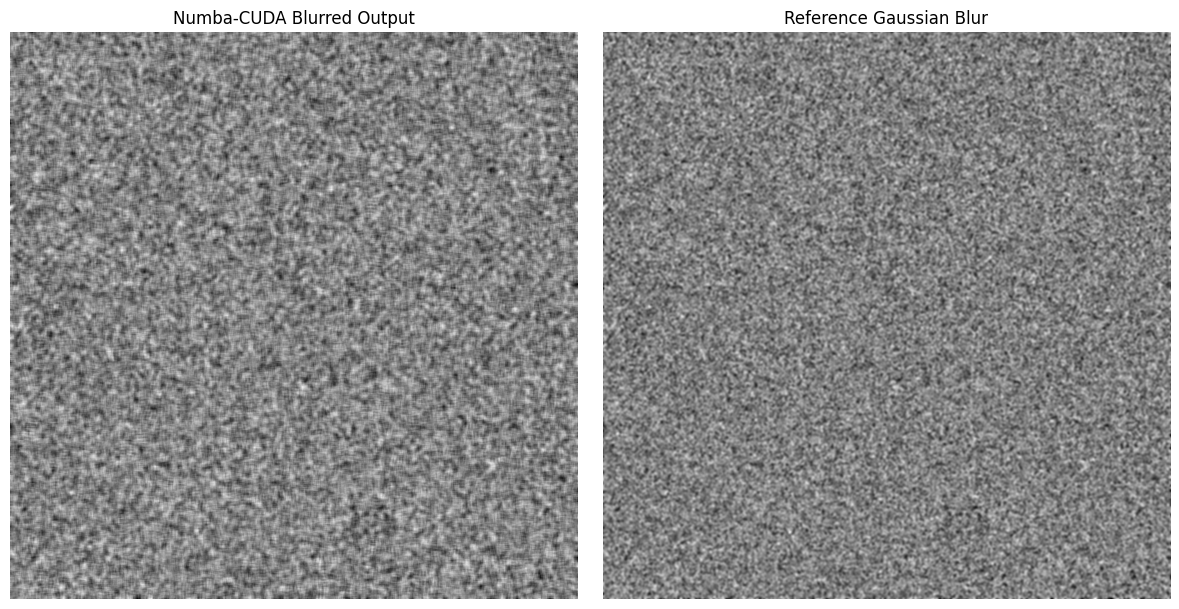

In [17]:
# Plot the fugure side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(out, cmap='gray')
axs[0].set_title("Numba-CUDA Blurred Output")
axs[0].axis('off')

axs[1].imshow(ref_blur, cmap='gray')
axs[1].set_title("Reference Gaussian Blur")
axs[1].axis('off')

plt.tight_layout()
plt.show()

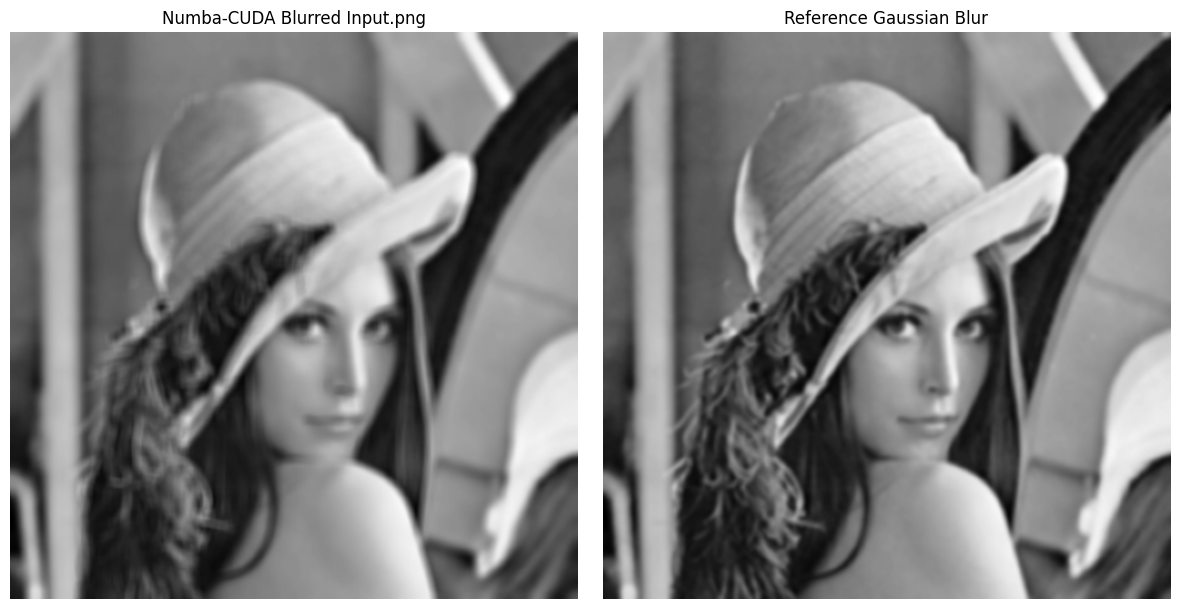

In [18]:
from skimage.io import imread
from skimage.color import rgb2gray
from skimage import img_as_ubyte

# 📥 Load input image (from your uploaded file)
img_path = 'input.png'
img_raw = imread(img_path)

# 🎨 Convert to grayscale if it's RGB
if img_raw.ndim == 3:
    img_gray = rgb2gray(img_raw)  # Convert to grayscale [0.0, 1.0]
    img = img_as_ubyte(img_gray)  # Convert to uint8 [0, 255]
else:
    img = img_raw.astype(np.uint8)  # Already grayscale

# 🧼 Prepare output array
out = np.empty_like(img)

# 🚀 GPU memory transfer
d_img = cuda.to_device(img)
d_out = cuda.device_array_like(img)

# 🚀 Launch CUDA blur kernel
blur_kernel[blocks_per_grid, threads_per_block](d_img, d_out, width, height)

# ⬅️ Copy result back
d_out.copy_to_host(out)

# 🎯 Reference Gaussian for visual comparison
ref_blur = filters.gaussian(img, sigma=2, truncate=2.0, mode='nearest')
ref_blur = (ref_blur * 255).astype(np.uint8)

# 📊 Plot both
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(out, cmap='gray')
axs[0].set_title("Numba-CUDA Blurred Input.png")
axs[0].axis('off')

axs[1].imshow(ref_blur, cmap='gray')
axs[1].set_title("Reference Gaussian Blur")
axs[1].axis('off')

plt.tight_layout()
plt.show()

##Problem 2 Image Blur Helper

###Problem 2: blur_kernel_helper code here

In [38]:
@cuda.jit
def blur_kernel_helper(input_img, output_img):
    TILE_WIDTH = 16
    RADIUS = 4
    SHARED_SIZE = TILE_WIDTH + 2 * RADIUS

    # Declare shared memory tile
    shared_tile = cuda.shared.array((24, 24), dtype=float32)

    # Thread and block info
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y
    bw = cuda.blockDim.x
    bh = cuda.blockDim.y

    # Global coordinates of output pixel
    x = bx * bw + tx
    y = by * bh + ty

    # Coordinates in shared memory
    shared_x = tx + RADIUS
    shared_y = ty + RADIUS

    height, width = input_img.shape

    # Load tile + halo into shared memory
    for dy in range(-RADIUS, RADIUS + 1):
        for dx in range(-RADIUS, RADIUS + 1):
            global_x = x + dx
            global_y = y + dy

            sx = shared_x + dx
            sy = shared_y + dy

            if 0 <= global_x < width and 0 <= global_y < height:
                shared_tile[sy, sx] = input_img[global_y, global_x]
            else:
                shared_tile[sy, sx] = 0.0

    cuda.syncthreads()

    # Only compute if inside image
    if y < height and x < width:
        total = 0.0
        count = 0
        for dy in range(-RADIUS, RADIUS + 1):
            for dx in range(-RADIUS, RADIUS + 1):
                total += shared_tile[shared_y + dy, shared_x + dx]
                count += 1

        output_img[y, x] = total / count


In [39]:
img.shape[1]

512

###Problem 2: Kernel Launch, Validation Code Here

In [40]:
from numba import float32

#NOTE: Use the image from the above code for submission.
height =img.shape[0]
width =img.shape[1]

# Transfer to GPU
    # INSERT CODE HERE
d_img=cuda.to_device(img.astype(np.float32))  # Input image to device (float32 for precision)  #Device image
d_out=cuda.device_array_like(d_img) #Image from the device

# Configure thread/block dimensions
threads_per_block = (16, 16)
blocks_per_grid = (
    math.ceil(height / threads_per_block[0]),
    math.ceil(width  / threads_per_block[1])
)

# Launch Kernel
    # INSERT CODE HERE blur_kernel_helper()
blur_kernel_helper[blocks_per_grid, threads_per_block](d_img, d_out)

# Copy result back
    # INSERT CODE
out_blur = d_out.copy_to_host().astype(np.uint8)  # Convert float32 back to uint8


# INSERT CODE HERE VALIDATION CODE HERE
    #This should be a visual comparison against the The Gaussian blur
    #using a low-pass filter in scikit-image
ref_blur = filters.gaussian(img, sigma=2, truncate=2.0, mode='nearest')
ref_blur = (ref_blur * 255).astype(np.uint8)


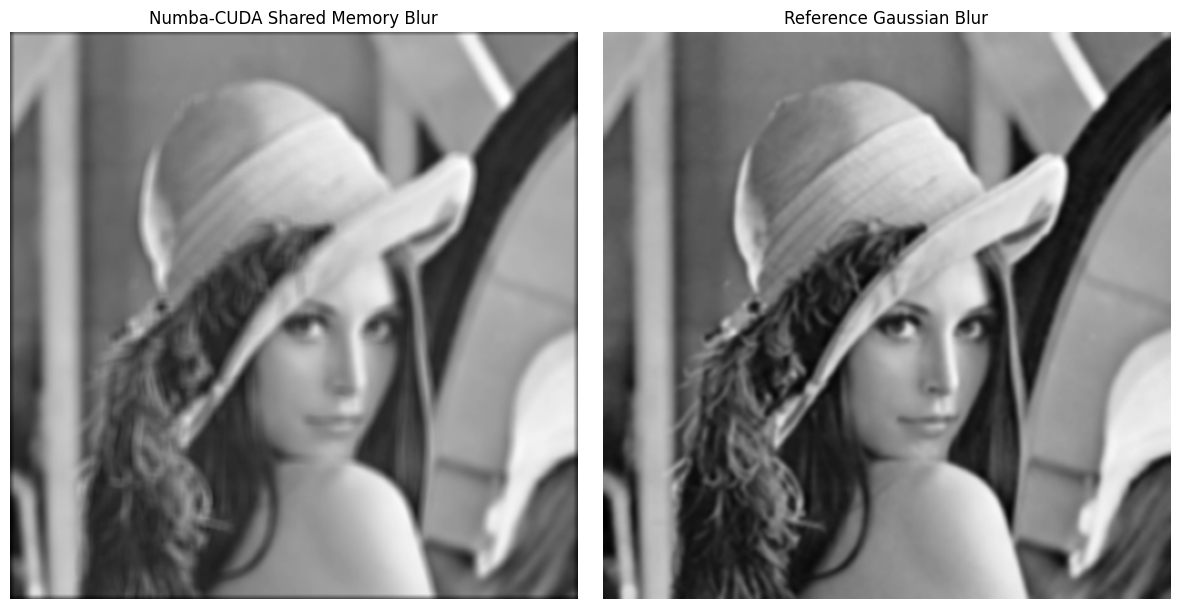

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(out_blur, cmap='gray')
axs[0].set_title("Numba-CUDA Shared Memory Blur")
axs[0].axis('off')

axs[1].imshow(ref_blur, cmap='gray')
axs[1].set_title("Reference Gaussian Blur")
axs[1].axis('off')

plt.tight_layout()
plt.show()

##Problem 3 Histogram

###Problem 3 histogram_kernel here

In [29]:
# -----------------------------------------------------------------------------
# GPU Kernel: block-shared 256-bin histogram
# -----------------------------------------------------------------------------
@cuda.jit
def histogram_kernel(data, histo):
    """
    Compute a 256-bin histogram of `data` (uint8 values) into `histo` (int32[256]).
    Uses per-block shared memory to reduce global-atomic contention.
    """

    """ INSERT KERNEL CODE BELOW """

    # Allocate shared histogram buffer in shared memory (compile-time size required)
    shared_hist = cuda.shared.array(256, dtype=int32)

    #  Thread & block info
    tx = cuda.threadIdx.x
    idx = cuda.grid(1)
    stride = cuda.gridsize(1)
    n = data.size

    #  Step 1: Initialize shared histogram to 0
    for i in range(tx, 256, cuda.blockDim.x):
        shared_hist[i] = 0
    cuda.syncthreads()

    # Step 2: Each thread processes a strided portion of the input
    while idx < n:
        val = data[idx]
        if 0 <= val < 256:
            cuda.atomic.add(shared_hist, val, 1)
        idx += stride
    cuda.syncthreads()

    # Step 3: Merge per-block shared histogram into global histogram
    for i in range(tx, 256, cuda.blockDim.x):
        cuda.atomic.add(histo, i, shared_hist[i])
    cuda.syncthreads()

###Problem 3: Kernel Launch, Validation Code Here

In [30]:
# generate random uint8 data
N = 10000000
h_data = np.random.randint(0, 256, size=N, dtype=np.uint8)

# allocate and zero global histogram on device
# INSERT CODE HERE

d_hist = cuda.device_array(256, dtype=np.int32)  # global histogram
d_hist[:] = 0

#Copy data to the device
# INSERT CODE HERE
d_data = cuda.to_device(h_data)

# launch parameters
# INSERT CODE HERE
threads_per_block = 256
blocks_per_grid = math.ceil(N / threads_per_block)

# run kernel
# INSERT CODE HERE
histogram_kernel[blocks_per_grid, threads_per_block](d_data, d_hist)

# copy back and print
# INSERT CODE HERE
h_hist = d_hist.copy_to_host()

#Print histogram
print("Histogram bins 0-9:", h_hist[:10])


# INSERT CODE HERE VALIDATION CODE HERE
    #This should be a visual comparison against a similar
    #histogram using Python Numpy
np_hist = np.bincount(h_data, minlength=256)

# Print partial comparison
print("GPU Histogram bins 0–9   :", h_hist[:10])
print("NumPy Histogram bins 0–9:", np_hist[:10])

# Optional: Check if histograms match
assert np.all(h_hist == np_hist), "❌ Histograms do not match!"
print("✅ GPU and NumPy histograms match.")

/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/dispatcher.py:579: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Histogram bins 0-9: [38956 39155 38887 38933 38806 39367 39328 38964 38702 38740]
GPU Histogram bins 0–9   : [38956 39155 38887 38933 38806 39367 39328 38964 38702 38740]
NumPy Histogram bins 0–9: [38956 39155 38887 38933 38806 39367 39328 38964 38702 38740]
✅ GPU and NumPy histograms match.


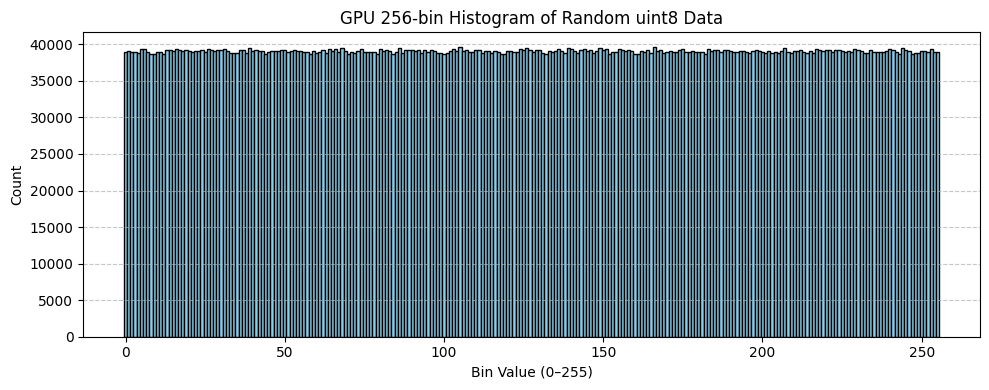

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.bar(np.arange(256), h_hist, width=1.0, color='skyblue', edgecolor='black')
plt.title("GPU 256-bin Histogram of Random uint8 Data")
plt.xlabel("Bin Value (0–255)")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
